In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=15,
       titlepad=11,
      )

from sklearn.feature_selection import mutual_info_regression

In [9]:
df = pd.read_csv("Datasets/customer.csv", index_col='Unnamed: 0')
df.head()

,Customer,State,CustomerLifetimeValue,Response,Coverage,Education,EffectiveToDate,EmploymentStatus,Gender,Income,...,MonthsSincePolicyInception,NumberofOpenComplaints,NumberofPolicies,PolicyType,Policy,RenewOfferType,SalesChannel,ClaimAmount,VehicleClass,VehicleSize
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer                    9134 non-null   object 
 1   State                       9134 non-null   object 
 2   CustomerLifetimeValue       9134 non-null   float64
 3   Response                    9134 non-null   object 
 4   Coverage                    9134 non-null   object 
 5   Education                   9134 non-null   object 
 6   EffectiveToDate             9134 non-null   object 
 7   EmploymentStatus            9134 non-null   object 
 8   Gender                      9134 non-null   object 
 9   Income                      9134 non-null   int64  
 10  LocationCode                9134 non-null   object 
 11  MaritalStatus               9134 non-null   object 
 12  MonthlyPremiumAuto          9134 non-null   int64  
 13  MonthsSinceLastClaim        9134 

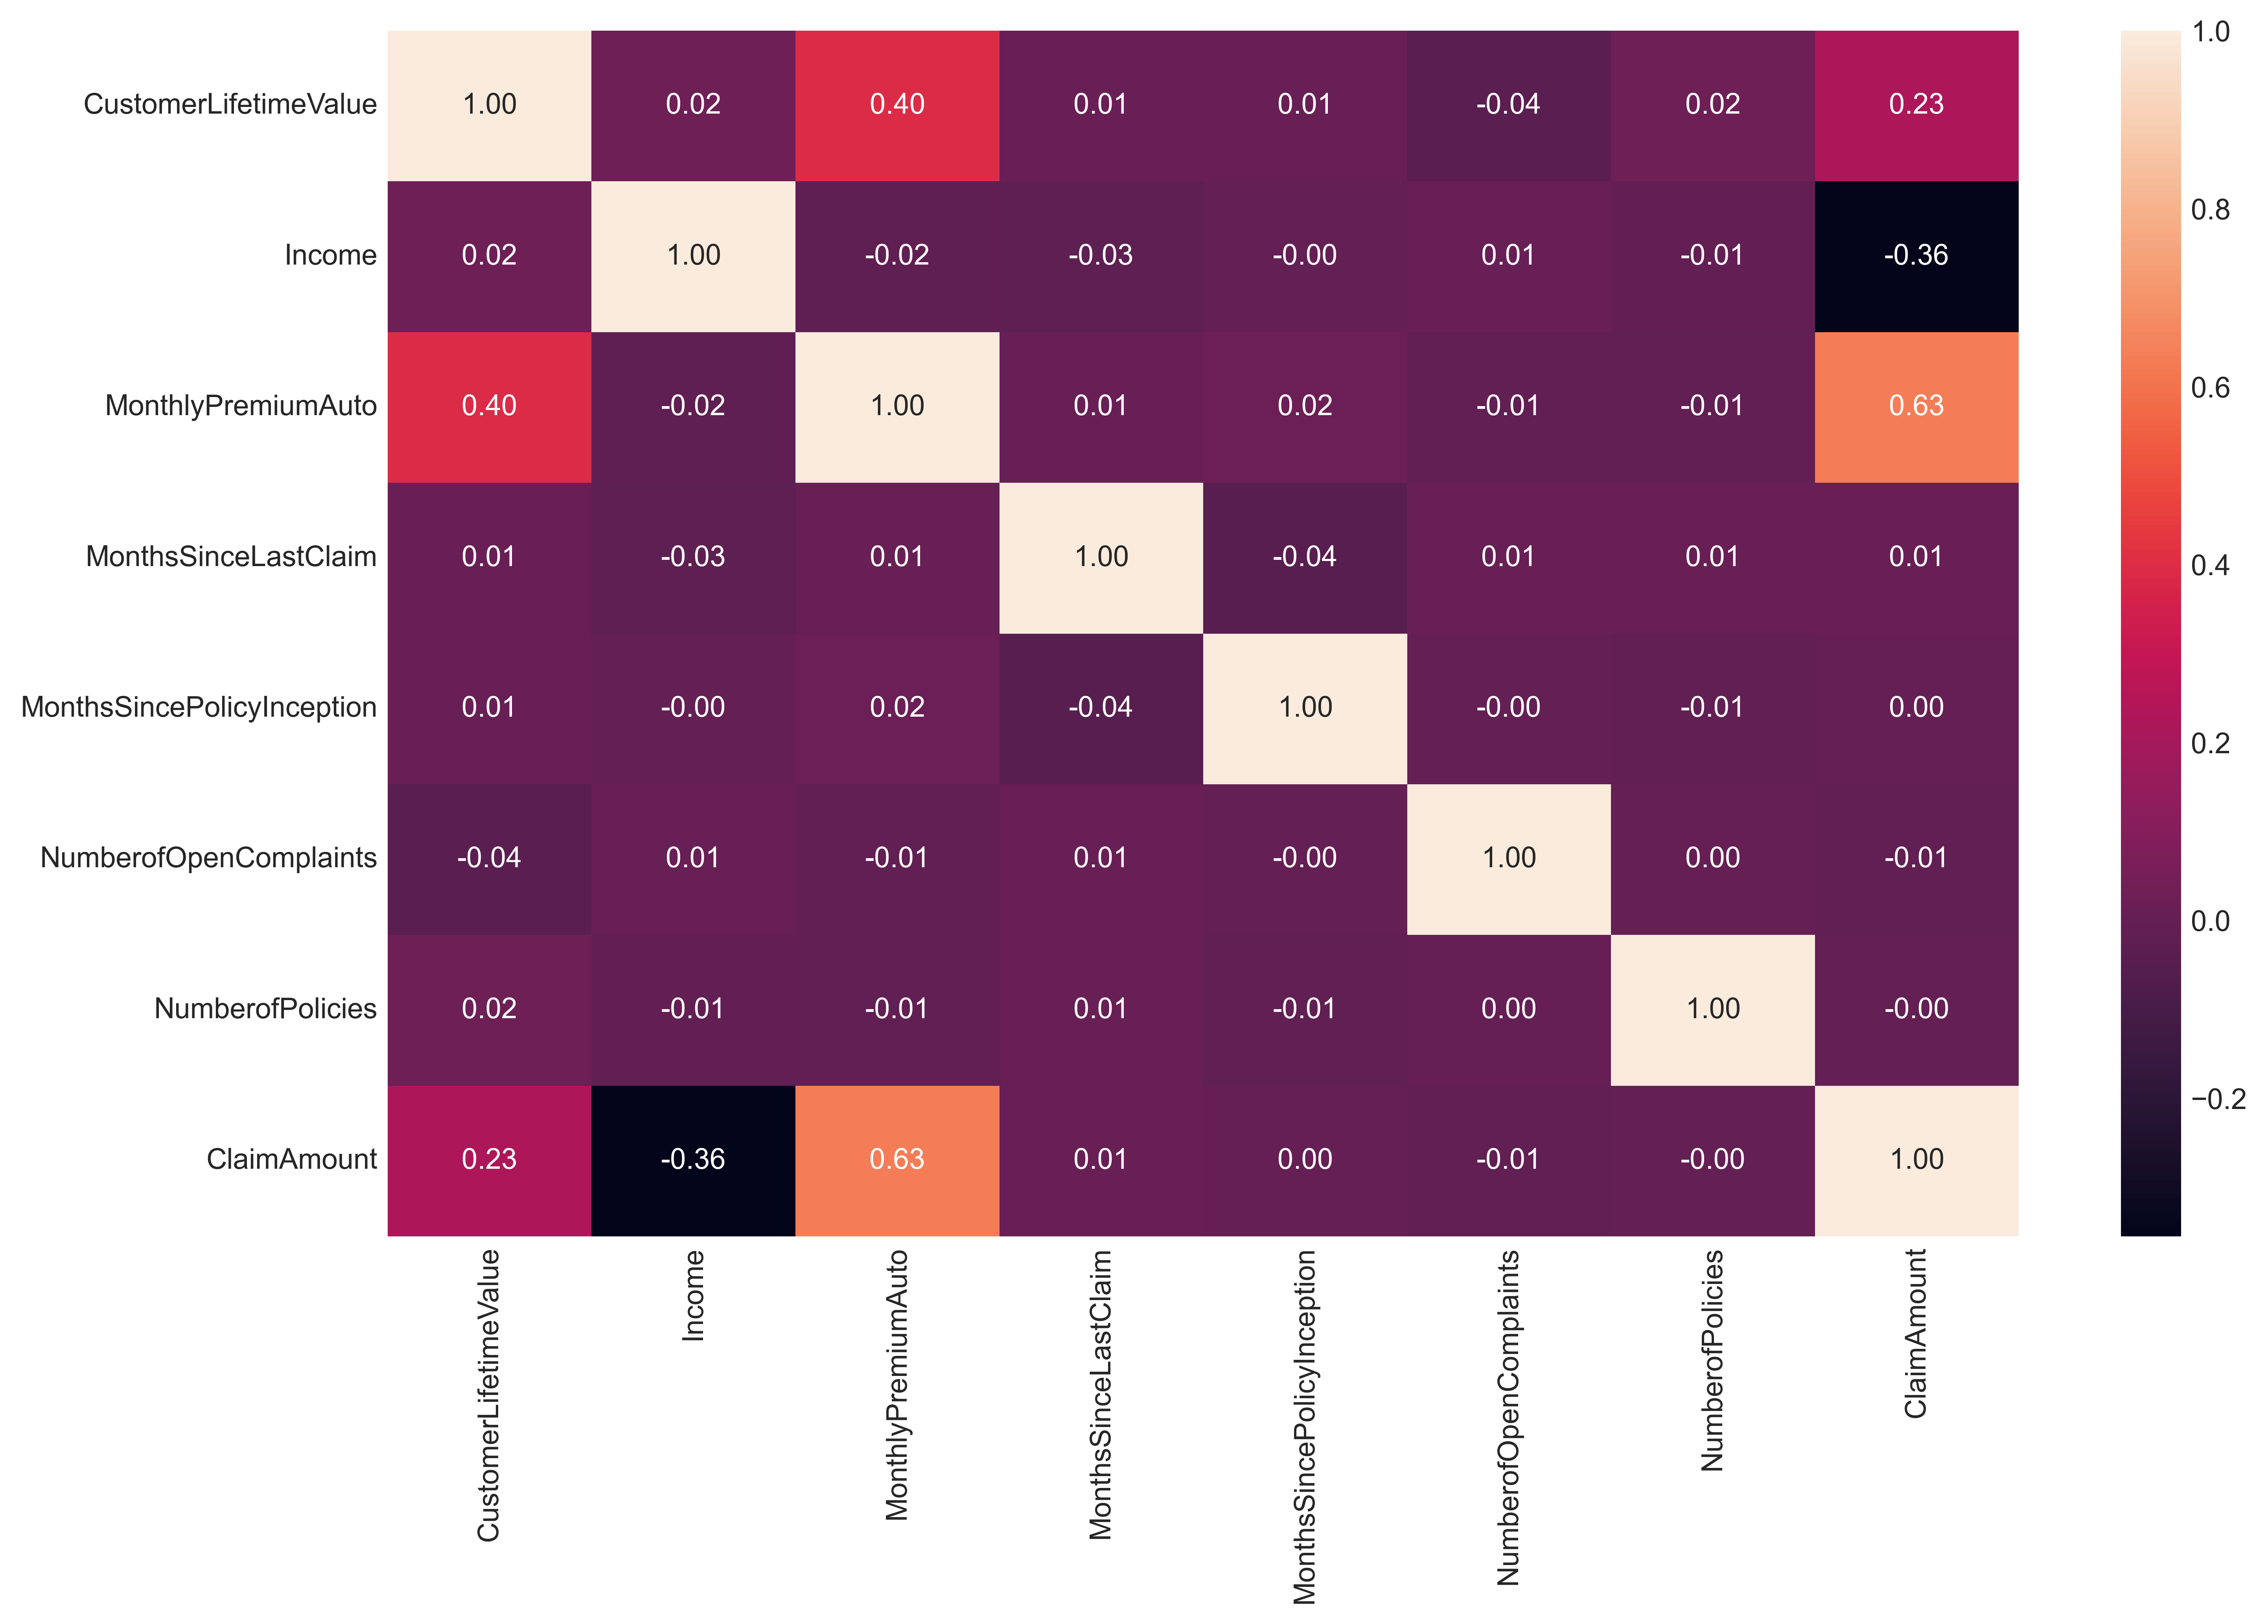

In [12]:
plt.figure(figsize=(12,8),dpi = 523)
sns.heatmap(df.corr(),
           annot=True,
            fmt='.2f'
           )
plt.show()

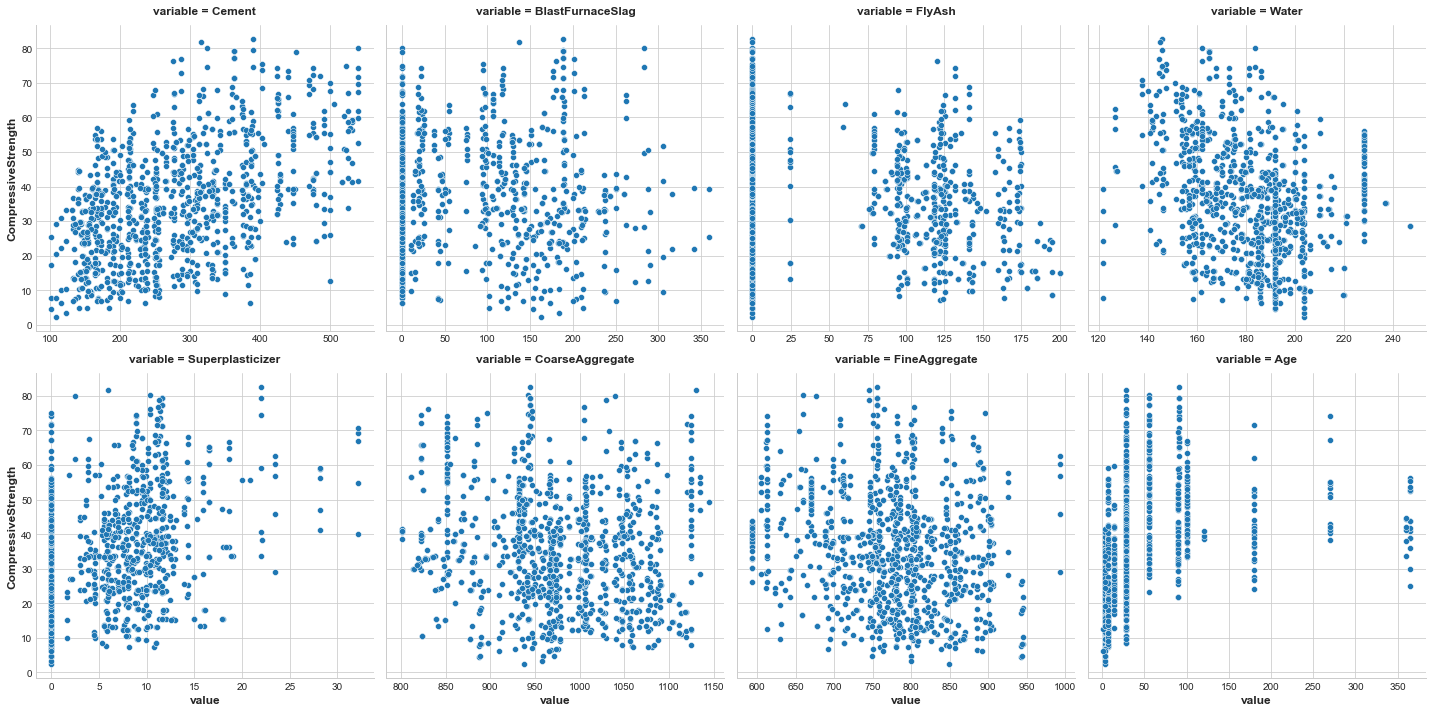

In [9]:
cantinuous = [col for col in df.columns if df[col].dtypes=='int64' or df[col].dtypes=='float64' ]
cantinuous

#Figure-level interface for drawing relational plots onto a FacetGrid.
sns.relplot(x="value", 
            y="CompressiveStrength", 
            col="variable",
            col_wrap=4,
            data=df.melt(id_vars="CompressiveStrength", value_vars=cantinuous),
            facet_kws=dict(sharex=False),
)
plt.show()

In [10]:
cat = [col for col in df.columns if df[col].dtypes=='object']
cat

[]

### Mutual Information

In [11]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
        
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

In [14]:
X = df.copy()
y = X.pop('CompressiveStrength')

mi_scores = make_mi_scores(X, y)
mi_scores

Age                 0.399457
Water               0.353731
Cement              0.307480
CoarseAggregate     0.254109
Superplasticizer    0.212838
FineAggregate       0.212487
BlastFurnaceSlag    0.180013
FlyAsh              0.123248
Name: MI Scores, dtype: float64

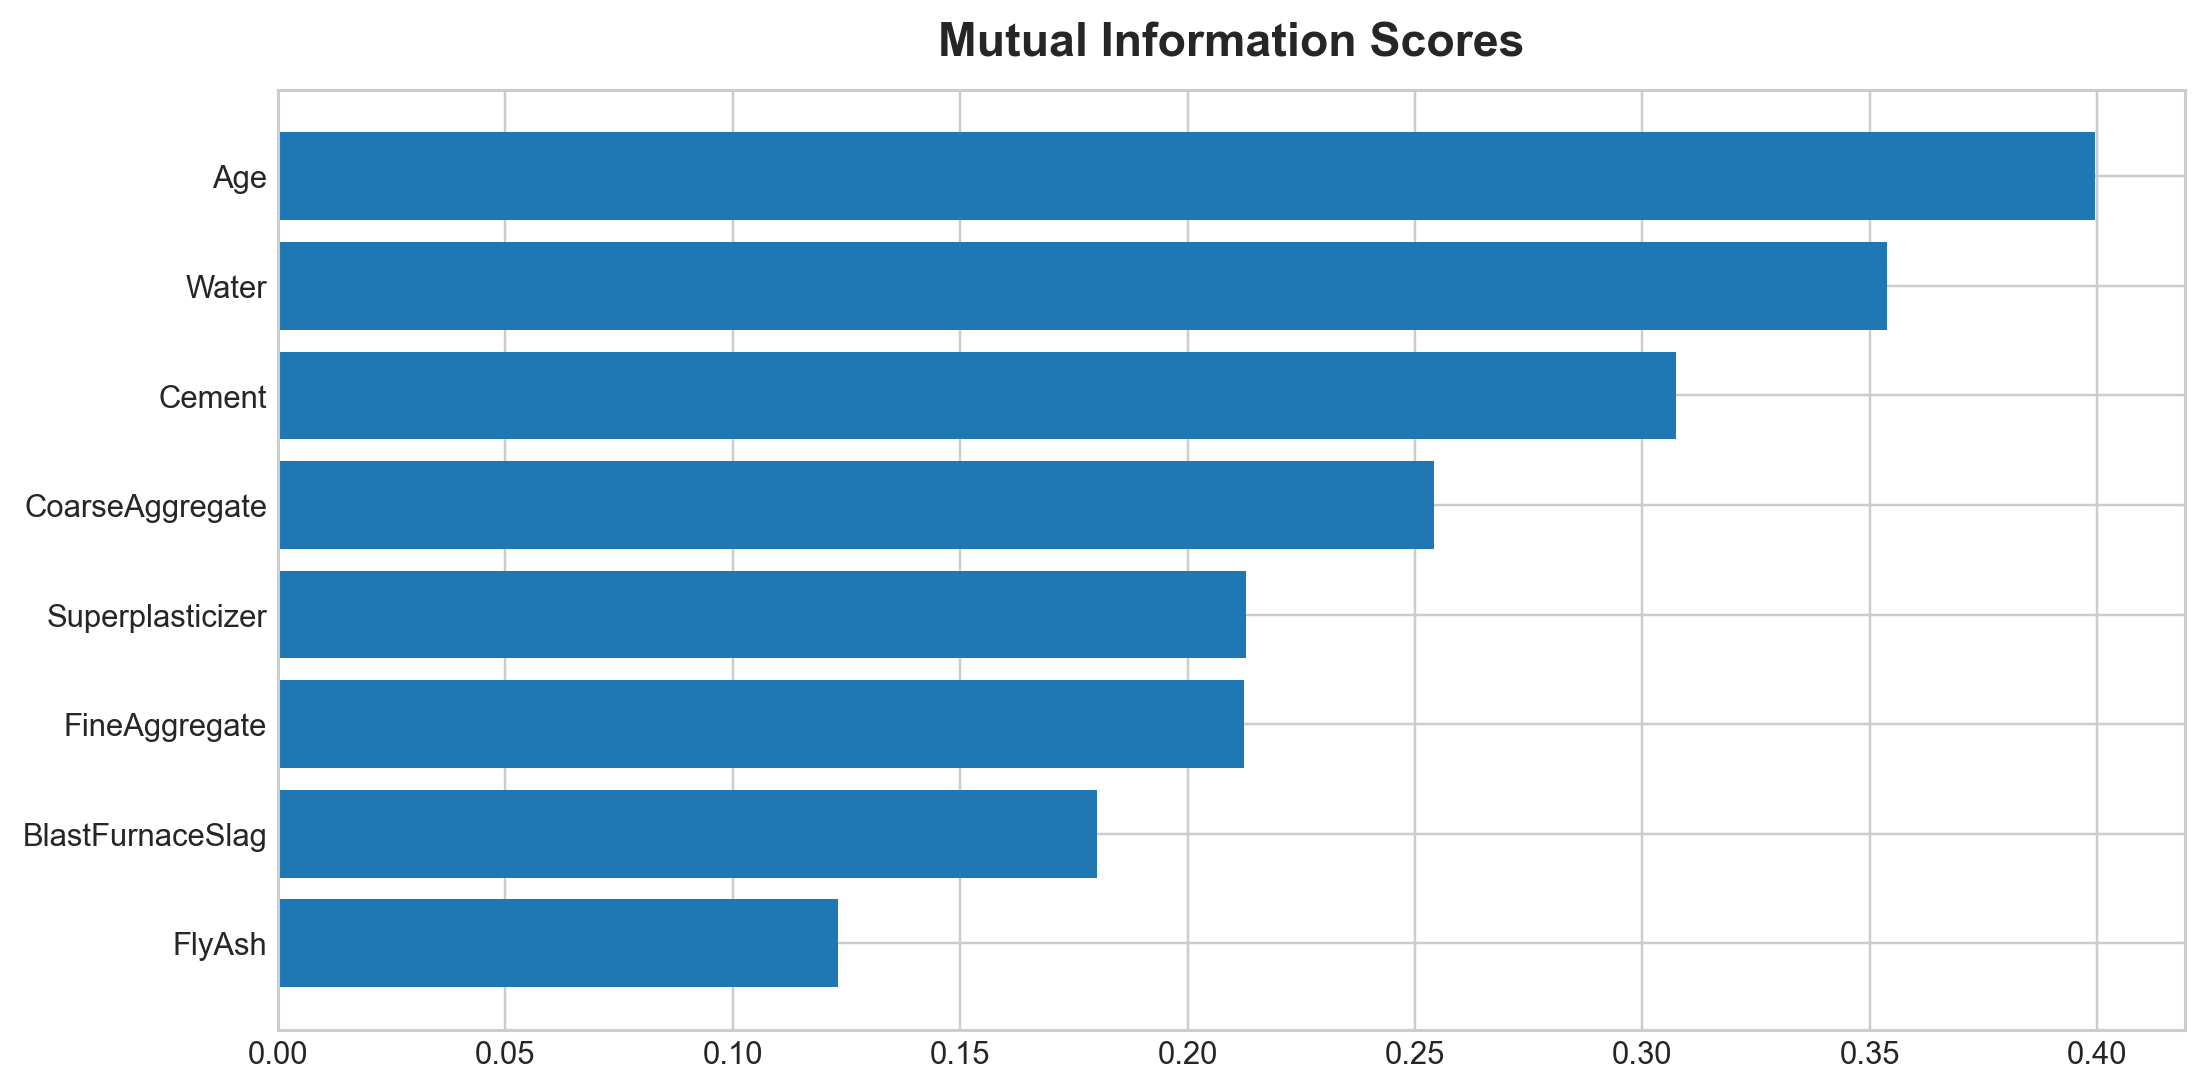

In [18]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=223, figsize=(10, 5))
plot_mi_scores(mi_scores)

## Building-Up and Breaking-Down Features¶

* ID numbers: `'123-45-6789'`
* Phone numbers: `'(999) 555-0123'`
* Street addresses: `'8241 Kaggle Ln., Goose City, NV'`
* Internet addresses: `'http://www.kaggle.com'`
* Product codes: `'0 36000 29145 2'`
* Dates and times: `'Mon Sep 30 07:06:05 2013'`

Features like these will often have some kind of structure that you can make use of. US phone numbers, for instance, have an area code (the `'(999)'` part) that tells you the location of the caller. As always, some research can pay off here.

The str accessor lets you apply string methods like `split` directly to columns. The Customer Lifetime Value dataset contains features describing customers of an insurance company. From the `Policy` feature, we could separate the `Type` from the `Level` of coverage:

In [13]:
df[["Type", "Level"]] = (        # Create two new features
    df["Policy"]                 # from the Policy feature
    .str                         # through the string accessor
    .split(" ",                  # by splitting on " "
               expand=True)      # and expanding the result into separate columns
)

df[["Policy", "Type", "Level"]].sample(10)

,Policy,Type,Level
6549,Personal L1,Personal,L1
950,Personal L3,Personal,L3
447,Special L1,Special,L1
4571,Personal L2,Personal,L2
7424,Personal L3,Personal,L3
2511,Corporate L2,Corporate,L2
7636,Corporate L3,Corporate,L3
5496,Personal L3,Personal,L3
249,Personal L2,Personal,L2
1782,Personal L3,Personal,L3


#  Group Transforms¶
Aggregate information across multiple rows grouped by some category

In [15]:
df["AverageIncome"] = (
    df.groupby("State")        # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

df[["State", "Income", "AverageIncome"]].sample(10)

,State,Income,AverageIncome
7174,California,51246,37558.946667
4124,Oregon,50994,37557.283353
8617,California,0,37558.946667
5025,Oregon,66152,37557.283353
1639,California,92850,37558.946667
5732,California,78255,37558.946667
3558,Arizona,25876,37405.402231
7878,Oregon,10312,37557.283353
4326,Oregon,0,37557.283353
9009,California,0,37558.946667


#### Calculate the frequency with which each state occurs in the dataset:

In [18]:
df["StateFreq"] = (df.groupby("State")
                   ["State"].transform("count") / df.State.count())

df[["State", "StateFreq"]].sample(10)

,State,StateFreq
7960,Oregon,0.284760
7492,Arizona,0.186446
9075,California,0.344865
3364,Oregon,0.284760
560,California,0.344865
1554,Arizona,0.186446
2736,Washington,0.087366
5702,California,0.344865
800,Oregon,0.284760
8459,Washington,0.087366


While training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's merge method after creating a unique set of values with drop_duplicates on the training set:

In [21]:
# Create splits
df_train = df.sample(frac=0.5)
df_valid = df.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].sample(5)

,Coverage,AverageClaim
864,Extended,471.933287
4118,Extended,471.933287
2312,Basic,378.955305
3715,Extended,471.933287
4446,Basic,378.955305


In [20]:
df_train[["Coverage", "AverageClaim"]].sample(5)

,Coverage,AverageClaim
3476,Premium,651.568468
7368,Basic,382.376487
6420,Basic,382.376487
3548,Basic,382.376487
7212,Extended,485.046716
7737,Basic,382.376487
8830,Extended,485.046716
1106,Basic,382.376487
1700,Basic,382.376487
801,Basic,382.376487


# Tips on Creating Features
It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:
* Linear models learn sums and differences naturally, but can't learn anything more complex.
* Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
* Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
* Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
* Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.